<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/devops_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neo4j openai langchain tiktoken

# Using a Knowledge Graph to implement a DevOps RAG application
## Leveraging knowledge graphs to power LangChain Applications
RAG applications are all the rage at the moment. Everyone is building their company documentation chatbot or similar. Mostly, they all have in common that their source of knowledge is unstructured text, which gets chunked and embedded in one way or another. However, not all information arrives as unstructured text.

Say, for example, you wanted to create a chatbot that could answer questions about your microservice architecture, ongoing tasks, and more. Tasks are mostly defined as unstructured text, so there wouldn't be anything different from the usual RAG workflow there. However, how could you prepare information about your microservices architecture so the chatbot can retrieve up-to-date information? One option would be to create daily snapshots of the architecture and transform them into text that the LLM would understand. However, what if there is a better approach? Meet knowledge graphs, which can store both structured and unstructured information in a single database.

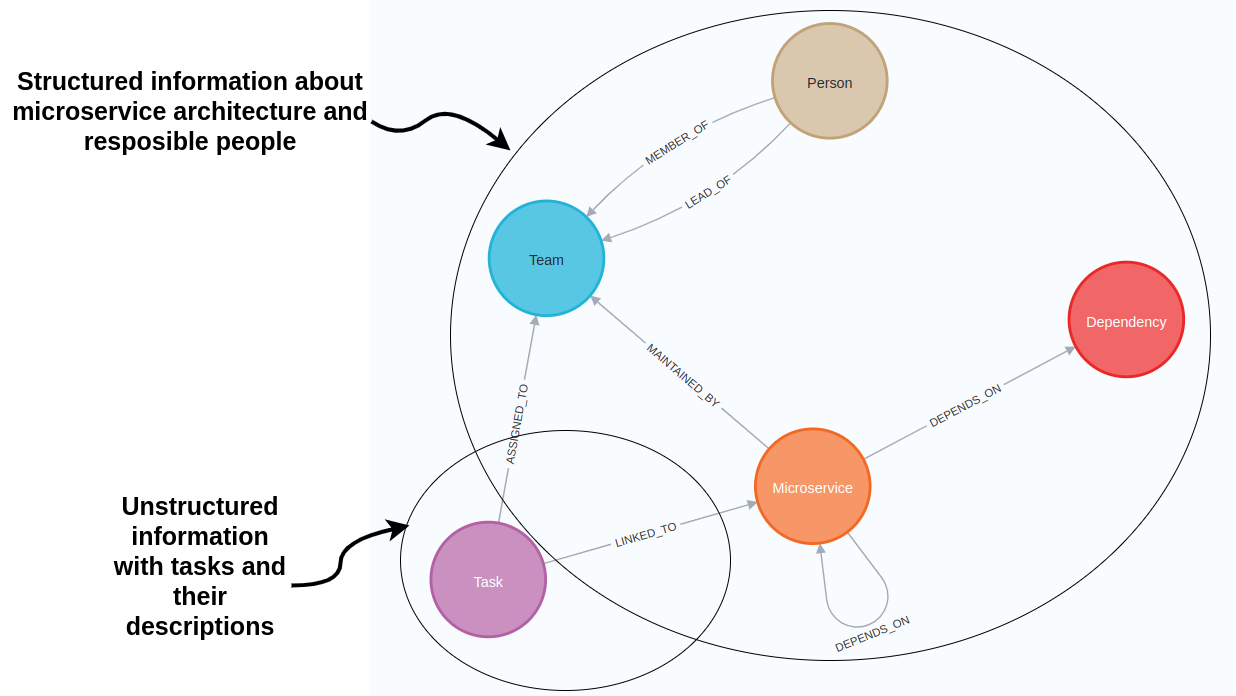

Nodes and relationships are used to describe data in a knowledge graph. Typically, nodes are used to represent entities or concepts like people, organizations, and locations. In the microservice graph example, nodes describe people, teams, microservices, and tasks. On the other hand, relationships are used to define connections between these entities, like dependencies between microservices or task owners.

Both nodes and relationships can have property values stored as key-value pairs.

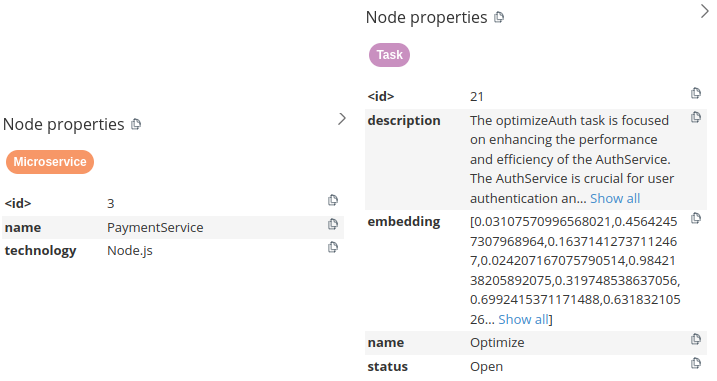

The microservice nodes have two node properties describing their name and technology. On the other hand, task nodes are more complex. They have the the name, status, description, as well as embedding properties. By storing text embedding values as node properties, you can perform a vector similarity search of task descriptions identical to if you had the tasks stored in a vector database. Therefore, knowledge graphs allow you to store and retrieve both structured and unstructured information to power your RAG applications.

In this blog post, I'll walk you through a scenario of implementing a knowledge graph based RAG application with LangChain to support your DevOps team. The code is available on GitHub.

## Neo4j Environment Setup

You need to set up a Neo4j 5.11 or greater to follow along with the examples in this blog post. The easiest way is to start a free instance on Neo4j Aura, which offers cloud instances of Neo4j database. Alternatively, you can also set up a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.

In [2]:
from langchain.graphs import Neo4jGraph

url = "neo4j+s://databases.neo4j.io"
username ="neo4j"
password = ""
graph = Neo4jGraph(
    url=url,
    username=username,
    password=password
)

## Dataset

Knowledge graphs are excellent at connecting information from multiple data sources. You could fetch information from cloud services, task management tools, and more when developing a DevOps RAG application.

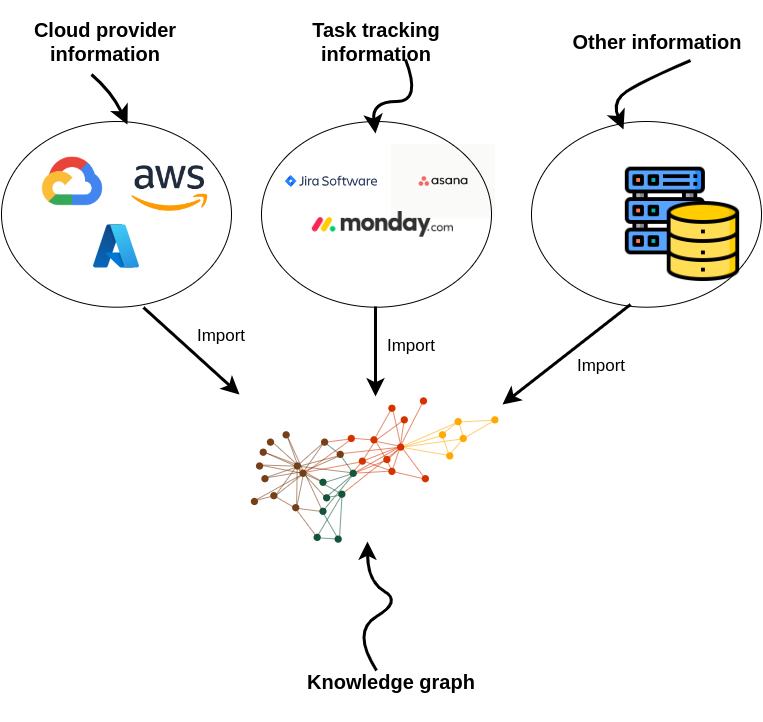

Since this kind of microservice and task information is not public, I had to create a synthetic dataset. I employed ChatGPT to help me. It's a small dataset with only 100 nodes, but enough for this tutorial. The following code will import the sample graph into Neo4j.

In [3]:
import requests
import_url = "https://gist.githubusercontent.com/tomasonjo/08dc8ba0e19d592c4c3cde40dd6abcc3/raw/e90b0c9386bf8be15b199e8ac8f83fc265a2ac57/microservices.json"
import_query = requests.get(import_url).json()['query']
graph.query(
    import_query
)

[]

## Neo4j Vector index
We will begin by implementing a vector index search for finding relevant tasks by their name and description. If you are unfamiliar with vector similarity search, let me give you a quick refresher. The key idea is to calculate the text embedding values for each task based on their description and name. Then, at query time, find the most similar tasks to the user input using a similarity metric like a cosine distance.

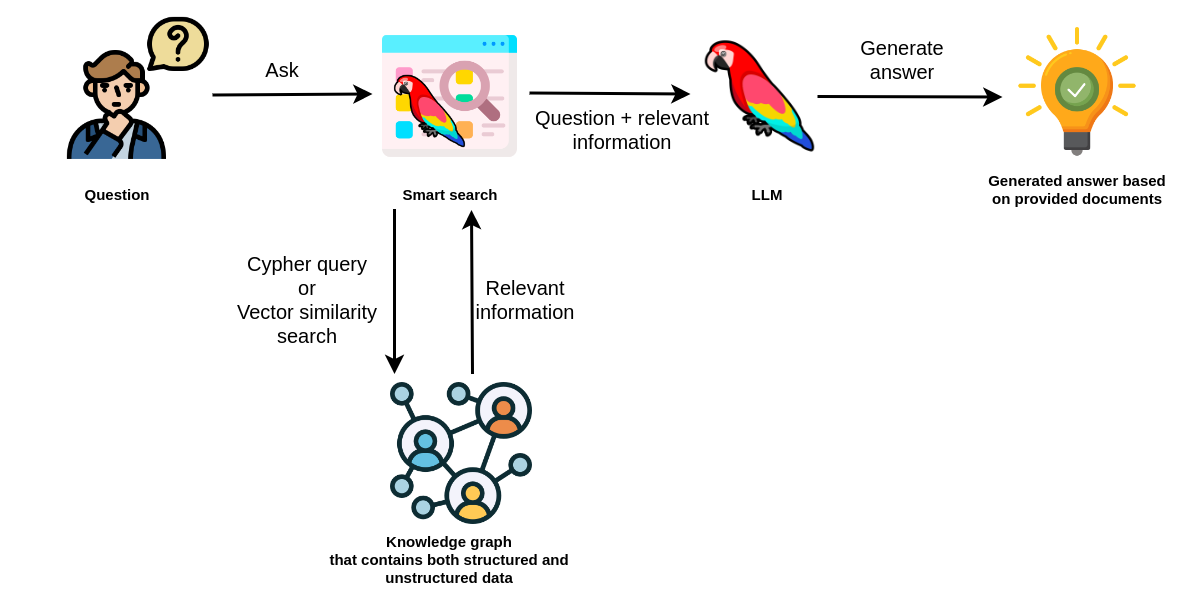


The retrieved information from the vector index can then be used as context to the LLM so it can generate accurate and up-to-date answers.

The tasks are already in our knowledge graph. However, we need to calculate the embedding values and create the vector index. This can be achieved with the from_existing_graph method.

In [4]:
import os
from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.embeddings.openai import OpenAIEmbeddings

os.environ['OPENAI_API_KEY'] = "sk-"

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password,
    index_name='tasks',
    node_label="Task",
    text_node_properties=['name', 'description', 'status'],
    embedding_node_property='embedding',
)

In this example, we used the following graph-specific parameters for the from_existing_graph method.

* index_name: name of the vector index
* node_label: node label of relevant nodes
* text_node_properties: properties to be used to calculate embeddings and retrieve from the vector index
* embedding_node_property: which property to store the embedding values to

Now that the vector index has been initiated, we can use it as any other vector index in LangChain.

In [5]:
response = vector_index.similarity_search(
    "How will RecommendationService be updated?"
)
print(response[0].page_content)


name: RecommendationFeature
description: Add a new feature to RecommendationService to provide more personalized and accurate product recommendations to the users, leveraging user behavior and preference data.
status: in progress


You can observe that we construct a response of a map or dictionary-like string with defined properties in the text_node_properties parameter.

Now we can easily create a chatbot response by wrapping the vector index into a RetrievalQA module.

In [6]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI

vector_qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(), chain_type="stuff", retriever=vector_index.as_retriever())

In [7]:
vector_qa.run(
    "How will recommendation service be updated?"
)

'The RecommendationService is currently in progress of being updated to include a new feature. The new feature aims to provide more personalized and accurate product recommendations to users by leveraging user behavior and preference data.'

One limitation of vector indexes, in general, is that they don't provide the ability to aggregate information like you would with a structured query language like Cypher. Take, for example, the following example:

In [8]:
vector_qa.run(
    "How many open tickets there are?"
)

'There are 4 open tickets.'

The response seems valid, and the LLM uses assertive language, making you believe the result is correct. However, the problem is that the response directly correlates to the number of retrieved documents from the vector index, which is four by default. What actually happens is that the vector index retrieves four open tickets, and the LLM unquestioningly believes that those are all the open tickets. However, the truth is different, and we can validate it using a Cypher statement.

In [9]:
graph.query(
    "MATCH (t:Task {status:'open'}) RETURN count(*)"
)

[{'count(*)': 5}]

There are five open tasks in our toy graph. While vector similarity search is excellent for sifting through relevant information in unstructured text, it lacks the capability to analyze and aggregate structured information. Using Neo4j, this problem can be easily solved by employing Cypher, which is a structured query language for graph databases.

## Graph Cypher search

Cypher is a structured query language designed to interact with graph databases and provides a visual way of matching patterns and relationships. It relies on the following ascii-art type of syntax:

```
(:Person {name:"Tomaz"})-[:LIVES_IN]->(:Country {name:"Slovenia"})
```
This patterns describes a node with a label Person and the name property Tomaz that has a LIVES_IN relationship to the Country node of Slovenia.
The neat thing about LangChain is that it provides a GraphCypherQAChain, which generates the Cypher queries for you, so you don't have to learn Cypher syntax in order to retrieve information from a graph database like Neo4j.
The following code will refresh the graph schema and instantiate the Cypher chain.

In [10]:
from langchain.chains import GraphCypherQAChain

graph.refresh_schema()

cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm = ChatOpenAI(temperature=0, model_name='gpt-4'),
    qa_llm = ChatOpenAI(temperature=0), graph=graph, verbose=True,
)

Generating valid Cypher statements is a complex task. Therefore, it is recommended to use state-of-the-art LLMs like gpt-4 to generate Cypher statements, while generating answers using the database context can be left to gpt-3.5-turbo.

Now, you can ask the same question about how many tickets are open.

In [11]:
cypher_chain.run(
    "How many open tickets there are?"
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (t:Task {status: 'open'}) RETURN COUNT(t)
Full Context:
[{'COUNT(t)': 5}]

> Finished chain.


'There are currently 5 open tickets.'

You can also ask the chain to aggregate the data using various grouping keys, like the following example.

In [12]:
cypher_chain.run(
    "Which team has the most open tasks?"
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (t:Task)-[:ASSIGNED_TO]->(team:Team)
WHERE t.status = 'open'
RETURN team.name, COUNT(t) AS OpenTasks
ORDER BY OpenTasks DESC
LIMIT 1
Full Context:
[{'team.name': 'TeamA', 'OpenTasks': 3}]

> Finished chain.


'TeamA has the most open tasks with a total of 3.'

You might say these aggregations are not graph-based operations, and you will be correct. We can, of course, perform more graph-based operations like traversing the dependency graph of microservices.

In [13]:
cypher_chain.run(
    "Which services depend on Database directly?"
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (m:Microservice)-[:DEPENDS_ON]->(n:Microservice {name: 'Database'}) RETURN m.name
Full Context:
[{'m.name': 'InventoryService'}, {'m.name': 'CatalogService'}, {'m.name': 'UserService'}, {'m.name': 'OrderService'}, {'m.name': 'AuthService'}, {'m.name': 'PaymentService'}]

> Finished chain.


'The services that depend on the Database directly are the InventoryService, CatalogService, UserService, OrderService, AuthService, and PaymentService.'

Of course, you can also ask the chain to produce variable-length path traversals by asking questions like:

In [14]:
cypher_chain.run(
    "Which services depend on Database indirectly?"
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (m:Microservice)-[:DEPENDS_ON*2..]->(n:Microservice {name: 'Database'}) RETURN m.name
Full Context:
[{'m.name': 'OrderService'}, {'m.name': 'PaymentService'}, {'m.name': 'OrderService'}, {'m.name': 'ShippingService'}, {'m.name': 'OrderService'}, {'m.name': 'UserService'}, {'m.name': 'OrderService'}]

> Finished chain.


'The services that depend on the Database indirectly are the OrderService, PaymentService, ShippingService, and UserService.'

Some of the mentioned services are the same as in the directly dependent question. The reason is the structure of the dependency graph and not the invalid Cypher statement.
## Knowledge graph agent
Since we have implemented separate tools for the structured and unstructured parts of the knowledge graph, we can add an agent that can use these two tools to explore the knowledge graph.

In [15]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

tools = [
    Tool(
        name="Tasks",
        func=vector_qa.run,
        description="""Useful when you need to answer questions about descriptions of tasks.
        Not useful for counting the number of tasks.
        Use full question as input.
        """,
    ),
    Tool(
        name="Graph",
        func=cypher_chain.run,
        description="""Useful when you need to answer questions about microservices,
        their dependencies or assigned people. Also useful for any sort of
        aggregation like counting the number of tasks, etc.
        Use full question as input.
        """,
    ),
]

mrkl = initialize_agent(
    tools, ChatOpenAI(temperature=0, model_name='gpt-4'), agent=AgentType.OPENAI_FUNCTIONS, verbose=True
)

Let's try out how well does the agent works.

In [16]:
response = mrkl.run("Which team is assigned to maintain PaymentService?")
print(response)



> Entering new AgentExecutor chain...

Invoking: `Graph` with `Which team is assigned to maintain PaymentService?`




> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (m:Microservice {name: 'PaymentService'})-[:MAINTAINED_BY]->(t:Team) RETURN t.name
Full Context:
[{'t.name': 'TeamD'}]

> Finished chain.
TeamD is assigned to maintain PaymentService.TeamD is assigned to maintain the PaymentService.

> Finished chain.
TeamD is assigned to maintain the PaymentService.


Let's now try to invoke the Tasks tool.

In [20]:
response = mrkl.run("Which tasks have optimization in their description?")
print(response)



> Entering new AgentExecutor chain...

Invoking: `Tasks` with `Which tasks have optimization in their description?`


The tasks that have optimization in their description are:

1. Optimize: Enhance AuthService’s performance and security by optimizing the authentication mechanisms and implementing additional security measures to safeguard user information.

2. Optimize: Optimize PaymentService by refining the transaction processing logic, reducing the service’s latency, and improving its reliability and efficiency in handling transactions.The tasks that have optimization in their description are:

1. Enhance AuthService’s performance and security by optimizing the authentication mechanisms and implementing additional security measures to safeguard user information.
2. Optimize PaymentService by refining the transaction processing logic, reducing the service’s latency, and improving its reliability and efficiency in handling transactions.

> Finished chain.
The tasks that have optimiz

One thing is certain. I have to work on my agent prompt engineering skills. There is definitely room for improvement in tools description. Additionally, you can also customize the agent prompt.
## Conclusion
Knowledge graphs are an excellent fit when you require structured and unstructured data to power your RAG applications. With the approach shown in this blog post, you can avoid polyglot architectures, where you must maintain and sync multiple types of databases. Learn more about graph-based search in LangChain here.